# 12-14.프로젝트 : CIFAR-10 이미지 생성하기

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.


# STEP 1. 데이터셋 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape
#cifar10데이터를 불러옵니다 이미지 쉐이프를 확인해봅니다.

(50000, 32, 32, 3)

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

In [3]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [4]:
train_x.shape

(50000, 32, 32, 3)

딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요합니다. 입력되는 이미지 데이터의 채널 수는 어떤 이미지냐에 따라 달라지는데요, 컬러 이미지의 경우 R, G, B 세 개의 채널이 있고, Gray Scale(흑백)의 경우 1개의 채널만 존재합니다. Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이죠. 따라서 데이터셋의 shape 마지막에 1을 추가해 주도록 하겠습니다.

In [5]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape #리쉐이프시 채널값을 추가해줍니다.

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/aiffel-dj57/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


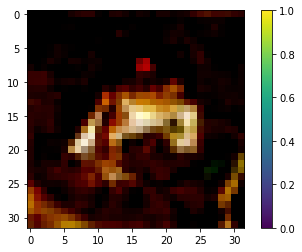

In [6]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar(cmap='rgb')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

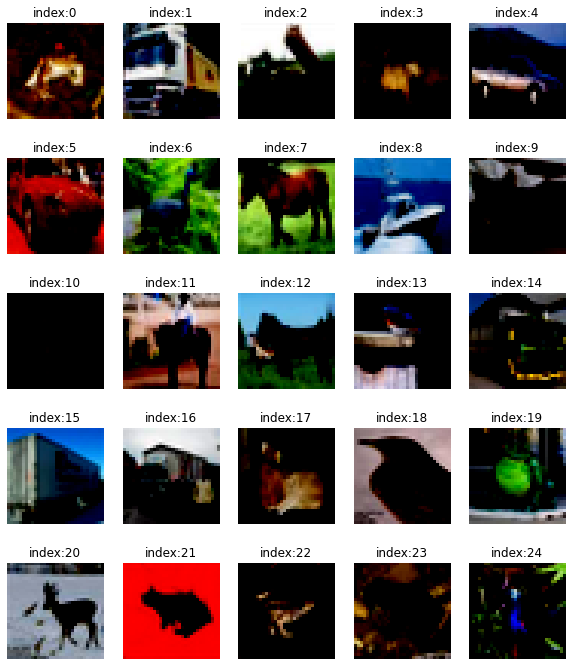

In [7]:
plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_x[i].reshape(32,32,3))
    plt.title(f'index:{i}')
    plt.axis('off')
plt.show()   

#이미지를 25개 꺼내서 살펴봅니다.

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256 #미니배치 학습

이렇게 정리된 데이터를 곧 모델에 넣어서 학습시켜야 하니, 편하게 사용할 수 있도록 텐서플로우의 Dataset을 이용해 준비해 놓도록 하겠습니다. 이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 됩니다. 어떻게 사용하는지는 곧 보도록 하죠.

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#  그림을 만들어내는 화가 생성자, 그리고 평가하는 비평가 판별자 (2) 생성자 구현하기

DCGAN(Deep Convolutional GAN)입니다. DCGAN은 GAN의 개념이 처음 소개된 1년 반 이후 발표된 논문으로서, 이전의 GAN을 더욱 발전시켜서 훨씬 그럴듯한 고화질 이미지 생성을 이루어낸 첫 번째 논문으로 평가받고 있습니다. 이후 발표된 수많은 GAN 기반 이미지 생성모델들은 대부분 DCGAN 모델을 발전시킨 형태라고 할 수 있으므로, 그 구조를 상세히 살펴보고 구현 연습을 해보는 것은 매우 의미 있다고 생각됩니다.

모델의 구현은 Keras Sequential API를 활용하겠습니다. 이후 소개하는 코드는 Tensorflow 2.0 Tutorial의 DCGAN 구현을 기반으로 상세한 설명을 추가하였습니다.



In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    #이후의 레이어에서 convolutional 연산을 할 수 있도록 1차원 벡터를 3차원 벡터로 변환한다.

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model


#마지막 Conv2DTranspose이미지가 32로 커질 수 있도록 준비해주었습니다

```Conv2DTranspose``` 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다. 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 1) 순으로 이미지를 키워나갑니다. 여기서 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일합니다.

#마지막으로 거친 쉐이프가 (32,32,1)이 되었더니 학습이 진행되지 않았습니다.
(32, 32, 3)이 되도록 수정합니다.

In [11]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [12]:
#shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보도록 하겠습니다.
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape
#첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

TensorShape([1, 32, 32, 3])

/home/aiffel-dj57/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  


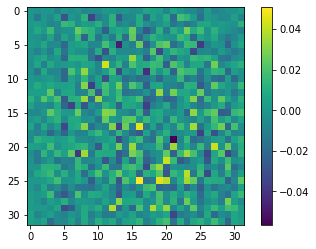

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar(cmap='rgb')
plt.show()
#matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

# 판별자 (3) 판별자 구현하기
판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 합니다.
그렇다면 입력은 (28, 28, 1) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것입니다.



In [15]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # normal #normal layer을 하나 더 추가해줍니다
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid')) #시그모이드 액티베이션 추가
    
    return model


Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됩니다.

In [16]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)        

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

In [17]:
#까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까요? 바로 확인해 봅시다.

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50017035]], dtype=float32)>

# 생성 모델이 똑똑해지기 위한 기나긴 여정 (1) 손실함수와 최적화 함수

## 손실함수(loss function)

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다.
교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이죠. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다.

자, 이쯤에서 다시 생성자와 판별자의 목적이 무엇이었는지 한번 정리해 볼까요? 생성자는 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어 합니다. 판별자는 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것이 목표입니다.

좋습니다!
그렇다면 Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠죠.

생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것
결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요! 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해 봅시다.

그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 (참고). 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.


```
바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.
이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다.
```

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용합니다.

fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
그럼 이제, fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.
이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다.

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

discriminator_loss
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!

최종 discriminator_loss 값은 이 둘을 더한 값입니다.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator accuracy
한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같습니다.

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
>> tf.Tensor([False, False, True, True])
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
>> tf.Tensor([0.0, 0.0, 1.0, 1.0])
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
>> 0.5


# 최적화 함수(optimizer)

자.. 그럼 손실함수는 모두 설계가 되었고, 이제 최적화 함수를 설정할 차례입니다. 이번에는 Adam 최적화 기법 을 활용해 보겠습니다.

참고: 문과생도 이해하는 딥러닝 (8) - 신경망 학습 최적화
Adam 함수 또한 tf.keras.optimizers 안에 있습니다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 설계


In [24]:
import numpy as np
import tensorflow as tf

def f(x,y):
    print(type(x))
    print(type(y))
    return x**2 + y

x = np.array([2,3])
y = np.array([3.-2])
f(x,y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([ 5., 10.])

In [25]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

# @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다. 

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음    
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함    
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기    
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성     
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후        real_output, fake_output 출력     
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산    
(7) accuracy 계산 : fake_output, real_output으로 discriminator가        
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산         
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신      
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴         

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    plt.show()

model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정이 담겨 있는데, 어딘가 익숙하지 않나요?

바로 우리가 위에서 해봤던, subplot을 이용해서 총 16개의 sample을 시각화하는 과정입니다. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화하는 것이죠.

또한, plt에 저장되어 보여지는 이미지를 plt.savefig로 간단히 파일화 해서 저장합니다.
다만, 우리가 원하는 것은 generated_samples라는 폴더 아래에 저장하는 것이므로 try 구문을 이용해 폴더가 없는 상황에 에러가 발생하는 것을 방지합니다. 만약 폴더가 없어서 에러가 난다면, except 구문으로 들어가 os.mkdir('./generated_samples')로 폴더를 만든 후 파일을 저장할 수 있습니다.

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없겠습니다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다. train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.



In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  
    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# (3) 학습 시키기

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
#checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

#latest = tf.train.latest_checkpoint(checkpoint_dir)
#checkpoint.restore(latest)

#generator = checkpoint.generator
#discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
#noise = tf.random.normal([1, 100])
#generated_image = generator(noise, training=False)

#np_generated = generated_image.numpy()
#np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
#np_generated = np_generated.astype(int)
#plt.imshow(np_generated[0])
#plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

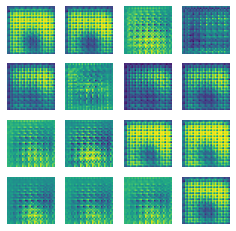

Time for training : 737 sec


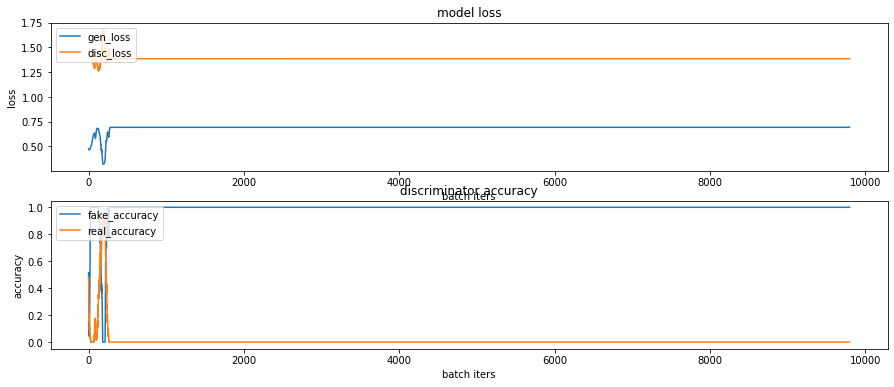

CPU times: user 11min 53s, sys: 27.2 s, total: 12min 20s
Wall time: 12min 17s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [34]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel-dj57 aiffel-dj57 2747143  3월  2 17:48 /home/aiffel-dj57/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![학습결과](https://i.imgur.com/H8Fp5oH.gif)

# 결과

200epoch 까지 돌려보았으나 학습 상태는 개선되지 않았고 속도만 느려졌다.
몇까지 논문들을 살펴보긴 했지만 실질적인 개선을 하기 위해서는 어떻게해야할지 갈피를 잘 못잡겠어요.

# GAN model이 가지고 있는 한계점

### MODE COLLAPSE
![이미지](https://miro.medium.com/max/638/1*wsNvHSUjGEJ1zNqi9FMqmA.png)

위의 이미지처럼 실제로는 속해있는 class가 다름에도 서로 비슷한 이미지가 생성되는 문제.
생성모델을 돌렸을때 매번 한가지의 사진만 생성되는현상이 발생

### UNROLLDED GAN

GAN 모델을 세울때 Generator와 Discriminator가 순차적으로 서로에게 영향을 끼치지 않으며 학습이 되기 MODE COLLAPSE 문제가 불생한다.
이를 해결하기 위해서는 GENERATOR와 DISCRIMINATOR를 서로 학습에 영향을 미치도록 설계하면 된다. 이렇게 나온 논문이 바로 Unrolled GAN이다.***기존의 GAN처럼 따로 학습하는 것이 아니라, G의 학습결과가 D의 학습에 영향을 끼치고, D의 학습결과가 G에 영향을 끼치는 구조로 학습이 되게 만든다!***


### surrogate loss function(surrogate objective function) 
학습을 통하여 parameter들을 업데이트 할때, 기존 방식은 G와 D 각자 따로 학습되는 반면, surrogate loss function에서는 D parameter 업데이트때 G와 D가 서로 영향을 끼치는 것을 알 수 있다.

이렇기 때문에, 기존 GAN에서 mode collapsing이 발생하는 원인을 조금이나마 없앨 수 있게 되어 좀 더 안정적인 학습이 가능하게 되었다.

